# パッケージ等のインストール

In [1]:
!pip install parsel selenium webdriver_manager

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00


In [2]:
%%shell
# 更新を実行
sudo apt -y update

# ダウンロードのために必要なパッケージをインストール
sudo apt install -y wget curl unzip
# 以下はChromeの依存パッケージ
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb

# Chromeのインストール
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

# Chrome Driverのインストール
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:9 http://archive.ubuntu.com/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,820 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,416 kB]
Get:14 http:

# ライブラリ読み込み、関数定義

In [3]:
import time, json, os, shutil, random
from datetime import datetime, timedelta

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from parsel import Selector
from urllib.parse import quote

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def enable_headless_download(driver, download_path):
    # Add missing support for chrome "send_command" to selenium webdriver
    driver.command_executor._commands["send_command"] = \
        ("POST", '/session/$sessionId/chromium/send_command')

    params = {'cmd': 'Page.setDownloadBehavior',
              'params': {'behavior': 'allow', 'downloadPath': download_path}}
    driver.execute("send_command", params)

In [5]:
def trend_scraper(keyword, download_path, since_date, until_date):
  geo = "JP"
  hl = 'ja'
  url = f'https://trends.google.co.jp/trends/explore?date={since_date}%20{until_date}&geo={geo}&q={quote(keyword)}&hl={hl}'
  print(url)

  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument("--lang=jp")
  options.add_argument("--no-sandbox")
  user_agent = ['Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36',
              'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36',
              'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36',
              'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
              ]
  options.add_argument('--user-agent=' + user_agent[random.randrange(0, len(user_agent), 1)])
  options.add_argument("--disable-dev-shm-usage")
  options.add_argument('--window-size=1920x1080')
  download_prefs = {'download.default_directory' : download_path,
                    'download.prompt_for_download' : False,
                    'profile.default_content_settings.popups' : 0}
  options.add_experimental_option('prefs', download_prefs)

  browser = webdriver.Chrome(options=options)
  browser.get(url)
  enable_headless_download(browser, download_path)

  # Load webpage
  browser.get(url)
  time.sleep(5)
  button = browser.find_element(By.CSS_SELECTOR, ".widget-actions-item.export")
  browser.execute_script("arguments[0].click();", button)
  time.sleep(5)
  browser.quit()

  # Rename download file
  filename_path = max([download_path +'/'+ f for f in os.listdir(download_path)],key=os.path.getctime)
  shutil.move(filename_path, os.path.join(download_path, f"{since_date}_{until_date}_{keyword}.csv"))

# 確認

In [6]:
#キーワード、ダウンロード先のパス、集めたい期間を指定
keyword = 'アイドル'
download_path = 'try/アイドル'
since_date = '2020-01-01'
until_date = '2020-01-31'

trend_scraper(keyword, download_path, since_date, until_date)

https://trends.google.co.jp/trends/explore?date=2020-01-01%202020-01-31&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%AB&hl=ja


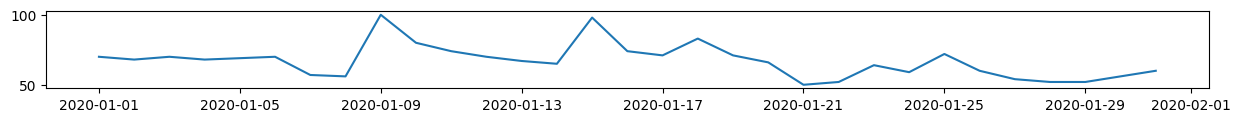

In [7]:
#確認
df = pd.read_csv(os.path.join(download_path,'2020-01-01_2020-01-31_アイドル.csv'), skiprows=2)
df.head()

plt.rcParams["figure.figsize"] = [15,1.0]
ax1 = plt.subplot(1,1,1)
ax1.plot(pd.to_datetime(df['日']), df['アイドル: (日本)'])

In [8]:
df.head(20)

,日,アイドル: (日本)
0,2020-01-01,70
1,2020-01-02,68
2,2020-01-03,70
3,2020-01-04,68
4,2020-01-05,69
5,2020-01-06,70
6,2020-01-07,57
7,2020-01-08,56
8,2020-01-09,100
9,2020-01-10,80


# メイン処理（ループ）10年集めるのに30分ぐらいかかる

In [11]:
#キーワード、ダウンロード先のパス、集めたい期間を指定
keyword = 'アイドル'
download_path = 'data/アイドル'
start_date = datetime(2010, 1, 1)
end_date = datetime(2019, 12, 31)

#以下1ヶ月ごと収集
current_date = start_date
while current_date <= end_date:
    next_month = current_date.month + 1 if current_date.month < 12 else 1
    next_year = current_date.year + 1 if current_date.month == 12 else current_date.year
    next_month_start = datetime(next_year, next_month, 1)
    current_month_end = next_month_start - timedelta(days=1)

    print("Start Date:", current_date.strftime("%Y-%m-%d"),
          "End Date:", current_month_end.strftime("%Y-%m-%d"))
    since_date = current_date.strftime("%Y-%m-%d")
    until_date = current_month_end.strftime("%Y-%m-%d")
    trend_scraper(keyword, download_path, since_date, until_date)

    current_date = next_month_start

Start Date: 2010-01-01 End Date: 2010-01-31
https://trends.google.co.jp/trends/explore?date=2010-01-01%202010-01-31&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%AB&hl=ja
Start Date: 2010-02-01 End Date: 2010-02-28
https://trends.google.co.jp/trends/explore?date=2010-02-01%202010-02-28&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%AB&hl=ja
Start Date: 2010-03-01 End Date: 2010-03-31
https://trends.google.co.jp/trends/explore?date=2010-03-01%202010-03-31&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%AB&hl=ja
Start Date: 2010-04-01 End Date: 2010-04-30
https://trends.google.co.jp/trends/explore?date=2010-04-01%202010-04-30&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%AB&hl=ja
Start Date: 2010-05-01 End Date: 2010-05-31
https://trends.google.co.jp/trends/explore?date=2010-05-01%202010-05-31&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%AB&hl=ja
Start Date: 2010-06-01 End Date: 2010-06-30
https://trends.google.co.jp/trends/explore?date=2010-06-01%202010-06-30&geo=JP&q=%E3%82%A2%E3%82%A4%E3%83%89%E3%83%A

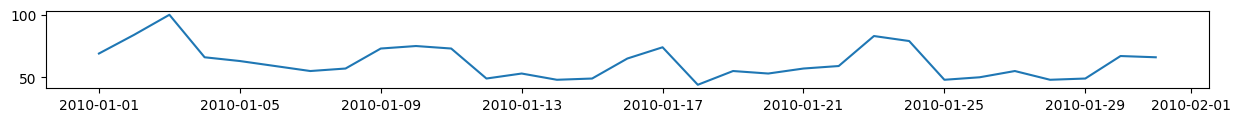

In [17]:
#確認
df = pd.read_csv(os.path.join(download_path,'2010-01-01_2010-01-31_アイドル.csv'), skiprows=2)
df.head()

plt.rcParams["figure.figsize"] = [15,1.0]
ax1 = plt.subplot(1,1,1)
ax1.plot(pd.to_datetime(df['日']), df['アイドル: (日本)'])

In [18]:
df.head(10)

,日,アイドル: (日本)
0,2010-01-01,69
1,2010-01-02,84
2,2010-01-03,100
3,2010-01-04,66
4,2010-01-05,63
5,2010-01-06,59
6,2010-01-07,55
7,2010-01-08,57
8,2010-01-09,73
9,2010-01-10,75
